In [6]:
import time
import matplotlib.pyplot as plt

class PIDController:
    def __init__(self, kp, ki, kd, setpoint=0, output_limits=(None, None)):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.setpoint = setpoint
        self.min_out, self.max_out = output_limits
        self._prev_error = 0
        self._integral = 0
        self._last_time = None

    def update(self, current_value, current_time=None):
        if current_time is None:
            current_time = time.time()
        
        # Handle first run
        if self._last_time is None:
            self._last_time = current_time
            return 0.0
            
        dt = current_time - self._last_time
        if dt <= 0.0: return 0.0

        error = self.setpoint - current_value
        
        # Proportional Term
        P_term = self.kp * error

        # Integral Term (with Anti-Windup Clamping)
        self._integral += error * dt
        if self.max_out is not None and (self._integral * self.ki) > self.max_out:
            self._integral = self.max_out / self.ki
        elif self.min_out is not None and (self._integral * self.ki) < self.min_out:
            self._integral = self.min_out / self.ki
            
        I_term = self.ki * self._integral

        # Derivative Term
        derivative = (error - self._prev_error) / dt
        D_term = self.kd * derivative

        # Total Output
        output = P_term + I_term + D_term

        # Final Output Limiting
        if self.max_out is not None and output > self.max_out:
            output = self.max_out
        elif self.min_out is not None and output < self.min_out:
            output = self.min_out

        self._prev_error = error
        self._last_time = current_time

        return output

In [7]:
def objective_function(x):
    # Example: minimum at x = 3
    return (x - 3)**2 + 1


In [8]:
def estimate_gradient(f, x, eps=1e-4):
    return (f(x + eps) - f(x - eps)) / (2 * eps)


In [9]:
# --- PID for Optimization ---
pid = PIDController(
    kp=2.0,
    ki=0.1,
    kd=0.2,
    setpoint=0,                  # target gradient = 0
    output_limits=(-5, 5)         # step-size limits
)

# Optimization state
x = -5.0                          # initial guess
dt = 0.05
current_time = 0.0
iterations = 400

history = {
    "time": [],
    "x": [],
    "f_x": [],
    "grad": [],
    "control": []
}

for i in range(iterations):
    grad = estimate_gradient(objective_function, x)

    # PID minimizes gradient
    control = pid.update(
        current_value=grad,
        current_time=current_time
    )

    # Apply control as parameter update
    x += control * dt

    # Log
    history["time"].append(current_time)
    history["x"].append(x)
    history["f_x"].append(objective_function(x))
    history["grad"].append(grad)
    history["control"].append(control)

    current_time += dt


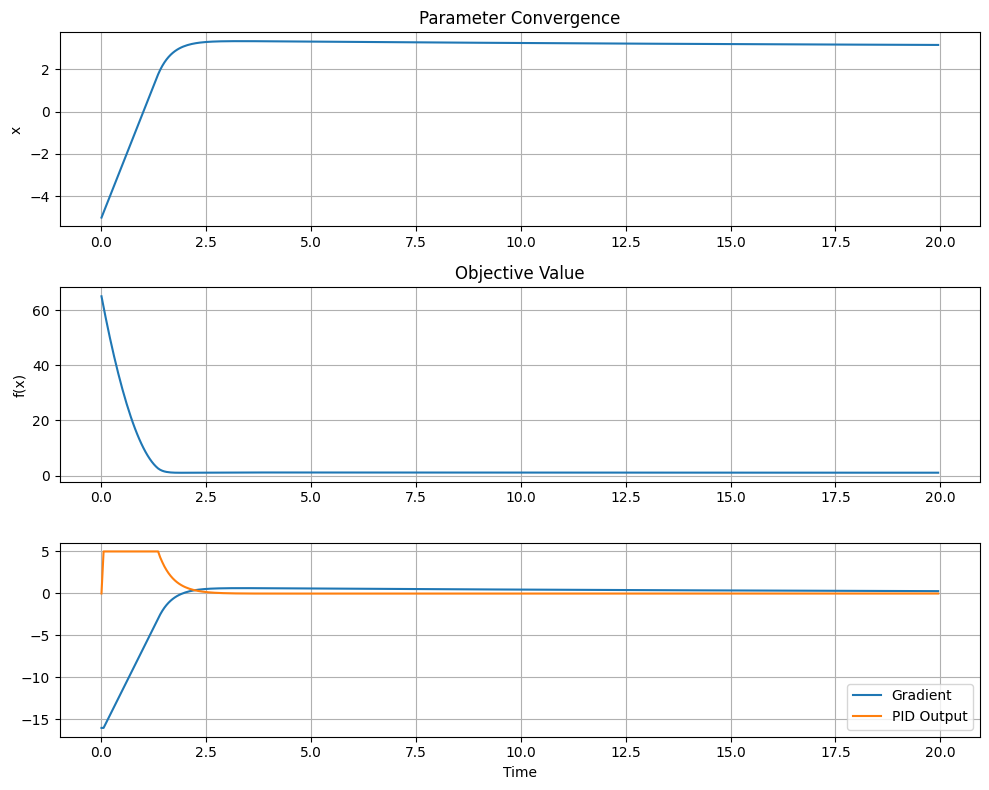

In [10]:
plt.figure(figsize=(10, 8))

plt.subplot(3, 1, 1)
plt.plot(history["time"], history["x"])
plt.ylabel("x")
plt.title("Parameter Convergence")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(history["time"], history["f_x"])
plt.ylabel("f(x)")
plt.title("Objective Value")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(history["time"], history["grad"], label="Gradient")
plt.plot(history["time"], history["control"], label="PID Output")
plt.xlabel("Time")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [23]:
import numpy as np

def x_star(t):
    return 3 + np.sin(0.5 * t)

def objective(x, t):
    return (x - x_star(t))**2


In [24]:
def estimate_gradient_time(f, x, t, eps=1e-4):
    return (f(x + eps, t) - f(x - eps, t)) / (2 * eps)


In [25]:
pid = PIDController(
    kp=3.0,
    ki=0.2,
    kd=0.4,
    setpoint=0,
    output_limits=(-5, 5)
)

x = 0.0
dt = 0.05
t = 0.0
steps = 600

log = {"t": [], "x": [], "x_star": [], "grad": [], "u": []}

for _ in range(steps):
    grad = estimate_gradient_time(objective, x, t)
    u = pid.update(grad, current_time=t)

    x += u * dt
    t += dt

    log["t"].append(t)
    log["x"].append(x)
    log["x_star"].append(x_star(t))
    log["grad"].append(grad)
    log["u"].append(u)



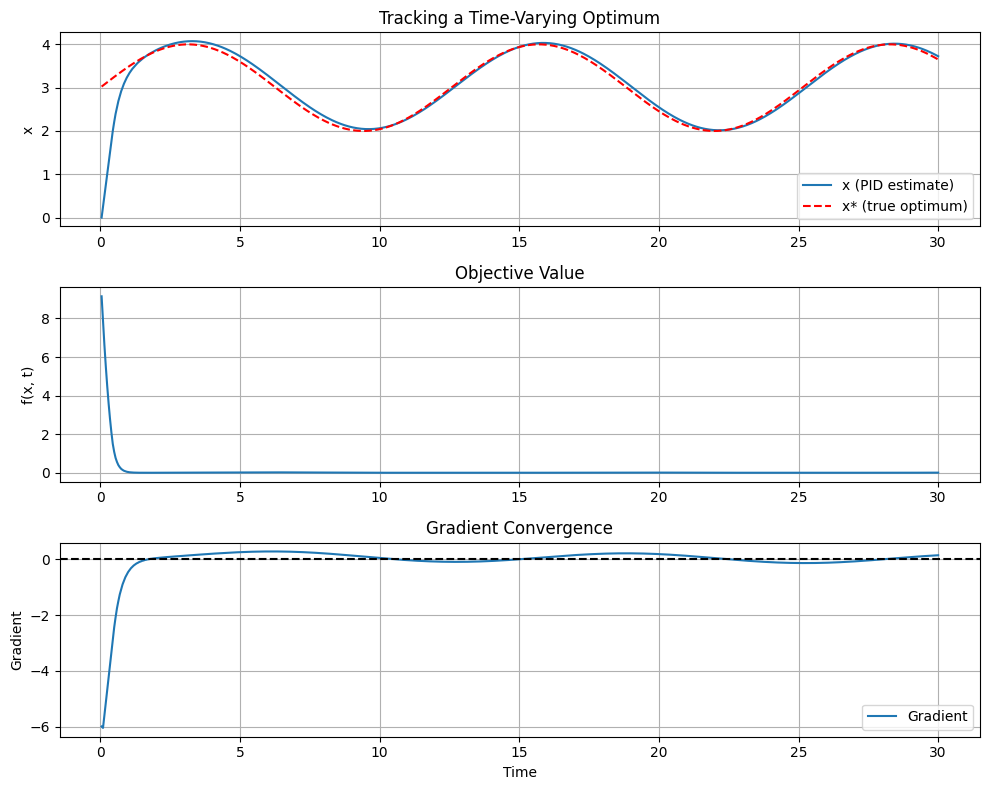

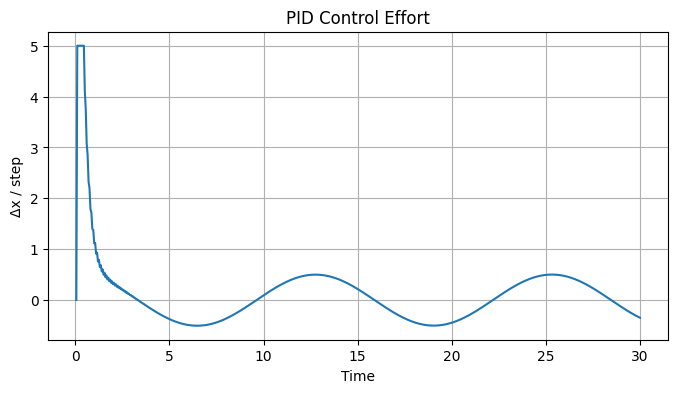

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

plt.subplot(3, 1, 1)
plt.plot(log["t"], log["x"], label="x (PID estimate)")
plt.plot(log["t"], log["x_star"], "r--", label="x* (true optimum)")
plt.ylabel("x")
plt.title("Tracking a Time-Varying Optimum")
plt.legend()
plt.grid(True)

f_vals = [objective(x, t) for x, t in zip(log["x"], log["t"])]

plt.subplot(3, 1, 2)
plt.plot(log["t"], f_vals)
plt.ylabel("f(x, t)")
plt.title("Objective Value")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(log["t"], log["grad"], label="Gradient")
plt.axhline(0, linestyle="--", color="k")
plt.xlabel("Time")
plt.ylabel("Gradient")
plt.title("Gradient Convergence")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(log["t"], log["u"])
plt.title("PID Control Effort")
plt.xlabel("Time")
plt.ylabel("Δx / step")
plt.grid(True)
plt.show()

